# 🏃‍♀️🏃‍♂️ Training: Multivariate time series model with long short-term memory (LSTM)


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Twist2

/content/gdrive/MyDrive/Twist2


## Load libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Change figure font sizes

In [4]:
# Adjust figure font sizes for better appearance
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

## Pollution monitoring site names

In [5]:
Site_Names = ['AJ_Jacobs','Bongani_Mabaso_Eco_Park','Leitrim','North_West_University_Vaal_campus','Sharpeville','Vanderbijlpark_NAQI','Zamdela_NAQI']


## Load data from the air_pollution_database

In [6]:
import sqlite3
import csv

con = sqlite3.connect("air_pollution_database.db")
cur = con.cursor()


### Seclect a site

In [7]:
site = Site_Names[5]
print(site)

Vanderbijlpark_NAQI


In [8]:
df = pd.read_sql(f'SELECT * FROM {site}',con)

df['datetime'] = df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)+' '+df.time.astype(str)+':00:00'
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.sort_values(by='datetime')

print(df.info())
#print(df.head())
#print(df.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36672 entries, 19199 to 19174
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             36672 non-null  int64         
 1   day              36672 non-null  int64         
 2   month            36672 non-null  int64         
 3   year             36672 non-null  int64         
 4   SO2              36672 non-null  object        
 5   O3               36672 non-null  object        
 6   PM2_5            36672 non-null  object        
 7   PM10             36672 non-null  object        
 8   PM_Coarse        36672 non-null  object        
 9   Toluene          36672 non-null  object        
 10  Amb_Wspeed       36672 non-null  object        
 11  Amb_WDirection   36672 non-null  object        
 12  Temperature      36672 non-null  object        
 13  Amb_RelHum       36672 non-null  object        
 14  Solar_Radiation  36672 non-null  o

In [9]:
con.close()

## Summary of avalible pollutants per site

In [10]:
if site == Site_Names[0]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'CO', 'PM2_5', 'PM10']
elif site == Site_Names[1]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'PM2_5', 'PM10']
elif site == Site_Names[2]:
  Pollutants = ['SO2', 'NO2', 'PM2_5', 'PM10']
elif site == Site_Names[3]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'PM2_5', 'PM10']
elif site == Site_Names[4]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'PM2_5', 'PM10']
elif site == Site_Names[5]:
  Pollutants = ['SO2','O3', 'PM2_5', 'PM10']
elif site == Site_Names[6]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'PM2_5', 'PM10']
else:
  print('Error: No valid site selected')

## Drop empty rows

In [11]:
df_new = df[Pollutants+['time','day','month','year','datetime']]
df_new=df_new.mask(df == '')
df_new.dropna(thresh=len(Pollutants), inplace=True)

print(df_new.info())
#print(df_new.head())
#print(df_new.tail())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36672 entries, 19199 to 19174
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SO2       30483 non-null  object        
 1   O3        13350 non-null  object        
 2   PM2_5     20268 non-null  object        
 3   PM10      30287 non-null  object        
 4   time      36672 non-null  int64         
 5   day       36672 non-null  int64         
 6   month     36672 non-null  int64         
 7   year      36672 non-null  int64         
 8   datetime  36672 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.8+ MB
None


## Pop datetime information

In [12]:
df_new_datetime = df_new.pop('datetime')

## Plot pollutant data

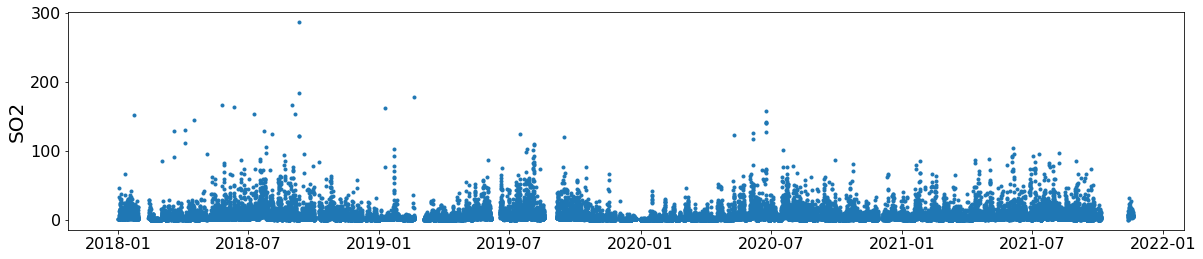

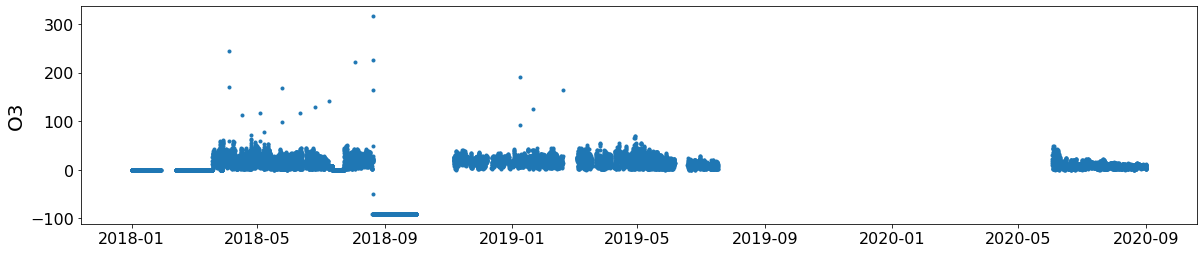

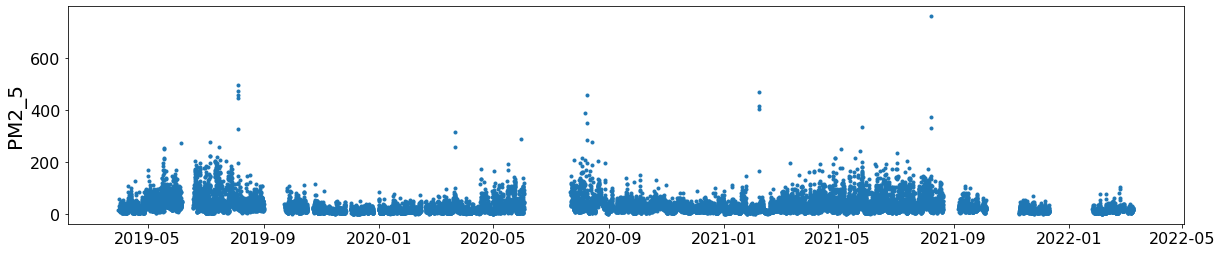

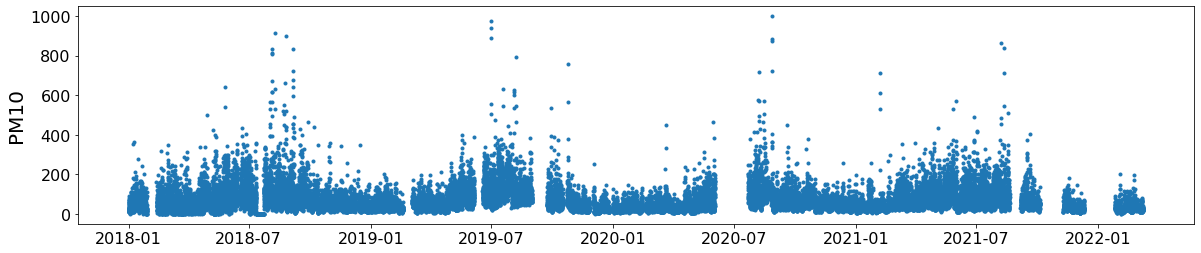

In [13]:
for pol in Pollutants:
  plt.figure(figsize=(20,4))
  plt.plot(df_new_datetime, df_new[pol],'.')
  plt.ylabel(pol)
  plt.show()

## Helper funtion to prepare data for training

In [ ]:
from sklearn.preprocessing import MinMaxScaler
 

def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
	''' Function to convert dataframe for use in supervised multivariate time series 
	machine learning learning task.

	Parameters
	---------------
	df:	pandas dataframe
		df is a dataframe containing time sereis data
	n_in:	int, default 1
		number of past time steps in
	n_out: int, default 1
		number of future time steps out

	Returns
	--------------
	agg: pandas dataframe
		prepared data
	'''

	n_vars = 1 if type(df) is list else len(df.columns)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


## Prepared data

In [ ]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_new.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=Pollutants+['time','day','month','year'])

# Save scaling
import joblib
scaler_filename = 'scaler_'+site+'.save'
joblib.dump(scaler, scaler_filename) 

# Frame as supervised learning
reframed = series_to_supervised(df_scaled, 1, 1)

# Drop columns we don't want to predict
reframed.drop(reframed.columns[[len(reframed.columns)-4,len(reframed.columns)-3,len(reframed.columns)-2,len(reframed.columns)-1]], axis=1, inplace=True)


In [ ]:
# Split into train and test sets
values = reframed.values
values = values.astype('float32')

# Number of training time steps
n_train = round(values.shape[0]*0.8)
# Keep one week for testing
n_valid = values.shape[0] - 7*24

train = values[:n_train, :]
valid = values[n_train:n_valid, :]
test = values[n_valid:, :]

# Split into input and outputs
train_X, train_y = train[:, :-len(Pollutants)], train[:, -len(Pollutants):]
valid_X, valid_y = valid[:, :-len(Pollutants)], valid[:, -len(Pollutants):]
test_X, test_y   = test[: , :-len(Pollutants)], test[ :, -len(Pollutants):]
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(values.shape,'Train shape:', train_X.shape, train_y.shape, 'Valid shape:', valid_X.shape, valid_y.shape, 'Test shape:',test_X.shape, test_y.shape)
print('Sanity check:', values.shape[0], train_X.shape[0]+valid_X.shape[0]+test_X.shape[0])

(3073, 12) Train: (2458, 1, 8) (2458, 4) Valid: (447, 1, 8) (447, 4) Test: (168, 1, 8) (168, 4)
Sanity check: 3073 3073


In [ ]:
print(train_X[1])
print(train_y[0])
print((Pollutants))

[[0.00333593 0.27160308 0.02023458 0.03184722 0.04347826 0.
  0.27272728 0.25      ]]
[0.00333593 0.27160308 0.02023458 0.03184722]
['SO2', 'O3', 'PM2_5', 'PM10']


## Define model architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(100, dropout = 0.2, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100, dropout = 0.2, activation='relu'))
model.add(Dense(len(Pollutants)))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# print layer shapes and model parameters
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 100)            43600     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
Total params: 124,404
Trainable params: 124,404
Non-trainable params: 0
_________________________________________________________________


## Train model

Epoch 1/50
2458/2458 [==============================] - 12s 4ms/step - loss: 0.0019 - accuracy: 0.9520 - val_loss: 0.0036 - val_accuracy: 0.9702
Epoch 2/50
2458/2458 [==============================] - 10s 4ms/step - loss: 0.0016 - accuracy: 0.9548 - val_loss: 0.0036 - val_accuracy: 0.9702
Epoch 3/50
2458/2458 [==============================] - 10s 4ms/step - loss: 0.0015 - accuracy: 0.9532 - val_loss: 0.0033 - val_accuracy: 0.9702
Epoch 4/50
2458/2458 [==============================] - 10s 4ms/step - loss: 0.0014 - accuracy: 0.9573 - val_loss: 0.0034 - val_accuracy: 0.9702
Epoch 5/50
2458/2458 [==============================] - 10s 4ms/step - loss: 0.0014 - accuracy: 0.9573 - val_loss: 0.0033 - val_accuracy: 0.9702
Epoch 6/50
2458/2458 [==============================] - 10s 4ms/step - loss: 0.0013 - accuracy: 0.9552 - val_loss: 0.0033 - val_accuracy: 0.9702
Epoch 7/50
2458/2458 [==============================] - 10s 4ms/step - loss: 0.0014 - accuracy: 0.9528 - val_loss: 0.0037 - val_ac

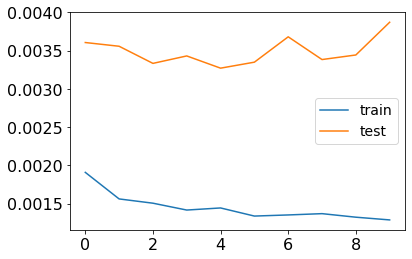

In [ ]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[earlystop])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Save model and history

In [ ]:
# Convert history dict to a pandas DataFrame     
hist_df = pd.DataFrame(history.history) 
# Save to csv
hist_csv_file = site+'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save model
import os
os.mkdir('./Model'+site)
model.save('./Model'+site)

INFO:tensorflow:Assets written to: ./ModelVanderbijlpark_NAQI/assets


INFO:tensorflow:Assets written to: ./ModelVanderbijlpark_NAQI/assets


## Test predictions

In [ ]:
# Make a prediction
yhat = model.predict(test_X)

In [ ]:
# Invert scaling
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, len(Pollutants):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

df_pred=pd.DataFrame(inv_yhat, columns=Pollutants+['time','day','month','year']) 
df_pred

,SO2,O3,PM2_5,PM10,time,day,month,year
0,5.342861,8.972296,51.429173,110.331100,18.0,24.0,8.0,2020.0
1,7.576796,7.840279,61.887695,127.584106,19.0,24.0,8.0,2020.0
2,5.877374,8.733812,54.259804,115.178337,20.0,24.0,8.0,2020.0
3,5.278325,9.128129,51.627426,111.051735,21.0,24.0,8.0,2020.0
4,4.884655,9.246655,50.339260,108.812355,22.0,24.0,8.0,2020.0
...,...,...,...,...,...,...,...,...
163,6.109167,8.583374,52.750767,112.334587,18.0,31.0,8.0,2020.0
164,7.261023,8.043583,55.436459,116.815857,19.0,31.0,8.0,2020.0
165,8.230021,8.016436,54.739182,115.528885,20.0,31.0,8.0,2020.0
166,4.589026,9.654991,48.134911,105.632820,21.0,31.0,8.0,2020.0


## Visualise prediction (1 hour into the future) and true values

In [ ]:
from sklearn.metrics import mean_squared_error

for pol in Pollutants:
  plt.figure(figsize=(20,4))
  plt.plot(df_new_datetime[-7*24:], df_new[pol][-7*24:],'.k',label='Measured')
  plt.plot(df_new_datetime[-7*24:], df_pred[pol],'.r',label='Predicted')
  plt.ylabel(pol)
  plt.legend()

  # calculate RMSE
  y_true = np.array(df_new[pol][-7*24:])
  g_ind = np.argwhere(pd.isna(y_true) == False  )
  g_ind = g_ind.reshape(g_ind.shape[0])
  # print(g_ind)
  if len(g_ind>0):
    rmse = np.sqrt(mean_squared_error(y_true[g_ind], df_pred[pol][g_ind]))
    print('Test RMSE: %.3f' % rmse)

  plt.show()